# Dog Breed Classification
The goal is to build a model capable of doing breed classification of a dog by just “looking” into its image. for this we will use the [Stanford Dog Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). It has around ~20 k images belonging to 120 classes and each image has an annotation associated with it.
We will have a try with a standard Machine learning approach without Neuronal network. The test will be run on 7 breeds. Note that No. of images per breed availiable for training data which is roughly ~300 images which seems quite small for the nature of this task. 

---

01. <a href="#1-Import-and-image-formating">Import and image formating</a>  
02. <a href="#2-Whitening">Whitening</a>  
03. <a href="#3-Semi-supervised-models">Descriptors</a>  
    3.1 <a href="#3.1-SIFT">SIFT</a>  
    3.2 <a href="#3.2-SURF">SURF</a>  
    3.3 <a href="#3.3-ORB">ORB</a> 
04. <a href="#4-Supervised-models">Baclustering</a>
05. <a href="#4-Supervised-models">Supervised models</a>  
06. <a href="#5-Conclusion"> Conclusion</a>



In [0]:
# install specific version of opencv for SIFT and SURF Algo  (decrepated in new versions)
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

    100% |████████████████████████████████| 25.0MB 1.5MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: opencv-python 3.4.5.20
    Uninstalling opencv-python-3.4.5.20:
      Successfully uninstalled opencv-python-3.4.5.20
    100% |████████████████████████████████| 30.6MB 1.4MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


In [0]:
# general
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data 
import os
import cv2     # opencv
import random  # schuffle dataset

# for clusters
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
import pandas as pd

# Perform PCA
from sklearn.decomposition import PCA
from sklearn import preprocessing

## t-SNE
from sklearn import manifold

# split data
from sklearn.model_selection import train_test_split


IMG_SIZE = 100  #  reshaped img size
cv2.__version__

'3.4.2'

In [0]:
# mount drive from MyGoogleDrive
from google.colab import drive  
drive.mount('/content/gdrive')

## 1 Input processing

### 1.1 Import

In [0]:
def create_training_data(path, img_resize=None):
    """read all pictures from the Stanford Dog Dataset structure"""
    training_data = []
    filename_l = []
    for filename in os.listdir(path):
        path2 = os.path.join(path, filename)
        filename_l.append(filename)
        class_w = filename.split(sep="-")[1]
        for img in os.listdir(path2):
            img_array = cv2.imread(os.path.join(path2, img)) # , cv2.IMREAD_GRAYSCALE)
            training_data.append([img_array, class_w])
        
    return training_data

In [0]:
# importing
path = "/content/gdrive/My Drive/Colab Notebooks/computer_vision/images/"
training_data = create_training_data(path)
print("{} pictures imported".format(len(training_data)))

# shuffle the data set
random.shuffle(training_data)

# separate images and labels
X = []
y = []
for feature, label in training_data:
    X.append(feature)
    y.append(label)
    
del training_data

1166 pictures imported


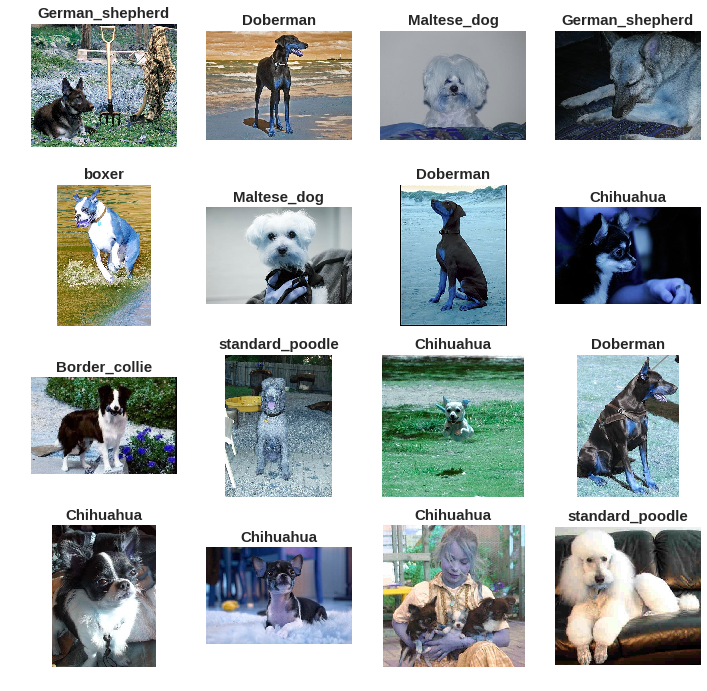

In [0]:
# example 16 pictures in a row

# idx of the first picture to plot
from_idx = 0

# plot
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,1+i)
    plt.title(y[i+from_idx], fontweight="bold", size=15)
    plt.imshow(X[i+from_idx])
    plt.axis('off')

plt.show;

### 1.2 Basic transformations

There are colors pictures with different shapes.
We will first standardize them in term of size and colors (gray).

In [0]:
# transformations: resize, grayscale, blur

X_gray = []
for i in range(len(X)):
    X_gray.append(cv2.resize(X[i], (IMG_SIZE, IMG_SIZE)))          # new size
    X_gray[i] = cv2.cvtColor(X_gray[i], cv2.COLOR_BGR2GRAY)        # convert to grayscale
    X_gray[i] = cv2.GaussianBlur(X_gray[i], ksize=(5,5), sigmaX=1) # Blurs using a Gaussian filter
X_gray = np.array(X_gray).reshape(-1, IMG_SIZE, IMG_SIZE)     # list of arrays to a full array
# del X
y = np.array(y) 

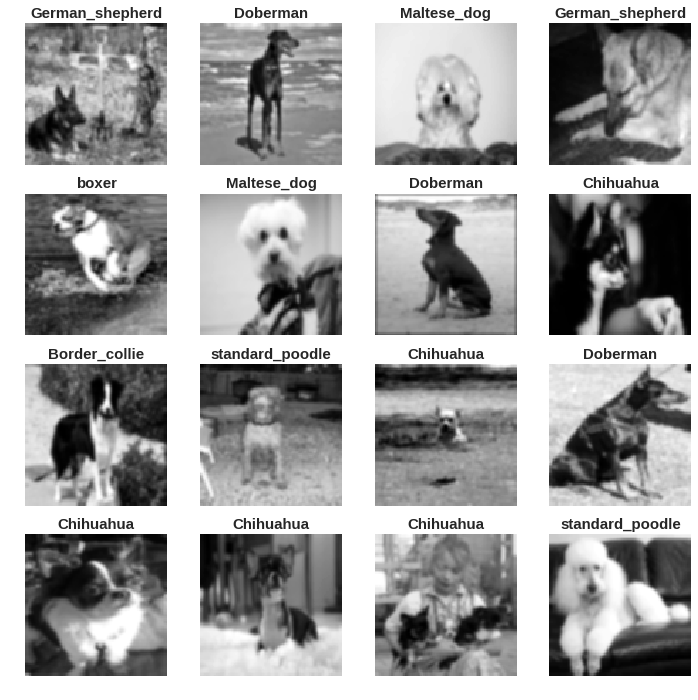

In [0]:
# example 16 pictures in a row

# idx of the first picture to plot
from_idx = 0

# plot
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,1+i)
    plt.title(y[i+from_idx], fontweight="bold", size=15)
    plt.imshow(X_gray[i+from_idx,:,:], cmap="gray")
    plt.axis('off')

plt.show;

In [0]:
# Save X and y to files
import pickle

pickle_out = open("X_gray.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y_gray.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [0]:
# load
import pickle
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

### 1.3 Whitening

In [0]:
# ZCA Whitening

# formating: reshape to a Nx10000 matrix
X_gray = X_gray.reshape(-1, IMG_SIZE*IMG_SIZE)

# compute the covariance of the image data
cov = np.cov(X_gray, rowvar=True)     # cov is (N, N)

# singular value decomposition
U,S,V = np.linalg.svd(cov)        # U is (N, N), S is (N,)

# build the ZCA matrix
epsilon = 1e-5
zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))  # (N,N)

# transform the image data         
X_zca = np.dot(zca_matrix, X_gray)     # X_zca is (N, 3072)

In [0]:
# rescale ZCA results to 0-250 (for SIFT)
def rescale(x, bottom=0, maximum=255):
    """linear rescale of an array x"""
    
    # conversion to float needed: for strange reasons x.min-x.max overflow calc
    x_min = float(x.min())   
    x_max = float(x.max())
    
    b = (maximum*x_min-bottom*x_max)/(x_min-x_max)
    a = (maximum-b)/x_max  
    return a*x+b

# reformat for SIFT: 
# rescale intensity to 0 - 255
X_zca = np.apply_along_axis(rescale, 1, X_zca)

# transform to int 8 bit
X_zca = X_zca.astype(np.uint8)

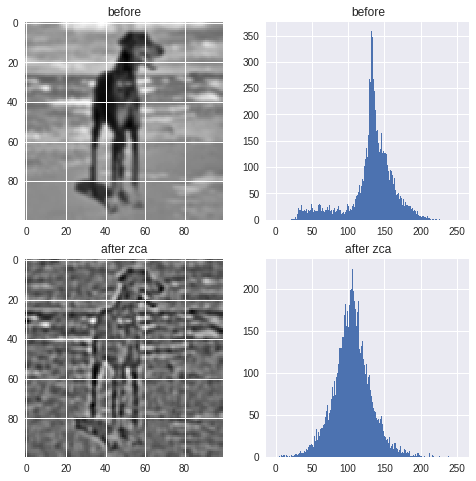

In [0]:
idx = 1
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.title("before")
plt.imshow(X_gray[idx].reshape((IMG_SIZE,IMG_SIZE)), cmap="gray")

plt.subplot(2,2,2)
plt.title("before")
n, bins, patches = plt.hist(X_gray[idx], bins=range(255), cumulative=False)

plt.subplot(2,2,3)
plt.title("after zca")
plt.imshow(X_zca[idx].reshape((IMG_SIZE,IMG_SIZE)), cmap="gray")

plt.subplot(2,2,4)
plt.title("after zca")
n, bins, patches = plt.hist(X_zca[idx], bins=range(255), cumulative=False)

plt.show;

## 3 Descriptors
In computer vision, visual descriptors or image descriptors are descriptions of the visual features of the contents in images, videos, or algorithms or applications that produce such descriptions. They describe elementary characteristics such as the shape, the color, the texture or the motion, among others. (source: [Wikipedia](https://en.wikipedia.org/wiki/Visual_descriptor))

In [0]:
# Functions to compute and plot descriptors


def compute_descriptors(X, method):
    """compute descriptors on each image of X. It returns 2 lists and one 
    dictionary.
    
    Inputs:
      - X: 2D Array of images  (N images x M pixels)
      - method: algorithm use to creat descriptors could be "sift", "surf", orb
    
    Outputs:
      - keypoints_all: list of all keypoints
      - descriptors_all: list of all descripot
      - img_descriptor_idx: dict of indexes. map img (X.index()) with keypoints/
        descriptors

    """

    methods = {"sift": cv2.xfeatures2d_SIFT.create(),
               "surf": cv2.xfeatures2d_SURF.create(),
               "orb": cv2.ORB_create(patchSize=10,
                                     edgeThreshold=10,
                                     nfeatures=50)
              } 
    descriptor_size = {"sift": 128, "surf": 64, "orb": 32} 

    # initialisation
    # apply to the fist image
    algo = methods[method]
    keypoints, descriptors = algo.detectAndCompute(X[0,:].reshape((IMG_SIZE, 
                                                                   IMG_SIZE)), 
                                                   None)
    
    n = 0
    img_descriptor_idx = {}
    keypoints_all = []  #list of keypoints of each pictures
    descriptors_all = np.empty((0,descriptor_size[method]))
    for idx in range(len(X)):
        img = X[idx].reshape((IMG_SIZE,IMG_SIZE))
        keypoints, descriptors = algo.detectAndCompute(img, None)

        descriptors_all = np.concatenate((descriptors_all, descriptors))
        keypoints_all.append(keypoints)
        img_descriptor_idx[idx] = list(range(n, n+len(descriptors)))
        n = n + len(descriptors) 
    
    return keypoints_all, descriptors_all, img_descriptor_idx


def plot_descriptors(X, method, img_descriptor_idx, keypoints_all, 
                    descriptors_all, img_idx=0, title="Descriptors"):
    """plot results for different descriptor from openCV library"""
    
    shapes = {"sift": (16,8),
             "surf": (8,8),
             "orb": (8,4)}
    descriptor_shape = shapes[method]
    gray = X[img_idx,:].reshape((IMG_SIZE,IMG_SIZE))
    idx_selection = img_descriptor_idx[img_idx]
    
    # plots
    plt.figure(figsize=(12,5))
    plt.suptitle(title,fontsize=20)
    plt.subplot(1,3,1)
    img = cv2.drawKeypoints(image=gray,
                            keypoints=keypoints_all[img_idx],
                            outImage=np.array([]),
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img, cmap="gray")

    plt.subplot(1,3,2)
    plt.title("Fist descriptor")
    plt.imshow(descriptors_all[idx_selection[0]].reshape(descriptor_shape))   
    plt.xlabel("Directions")
    plt.ylabel("Sub-aera")

    plt.subplot(1,3,3)
    plt.title("Second descriptor")
    plt.imshow(descriptors_all[idx_selection[1]].reshape(descriptor_shape))   
    plt.xlabel("Directions")
    plt.ylabel("Sub-aera")
    plt.show;

### 3.1 SIFT
The scale-invariant feature transform (SIFT) is a feature detection algorithm in computer vision to detect and describe local features in images. More info: [openCV docs](https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html)

In [0]:
sift_keypoints_all, sift_descriptors_all, sift_img_descriptor_idx = compute_descriptors(X_zca, "sift")

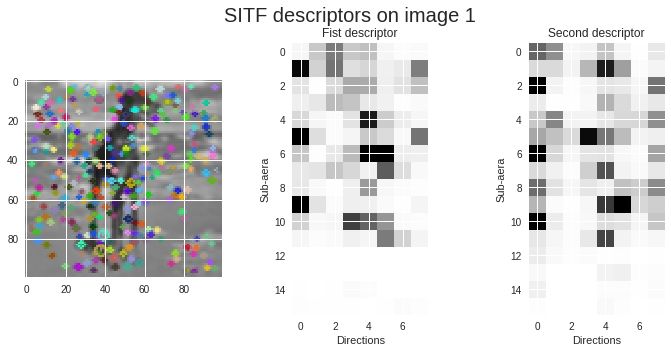

In [0]:
plot_descriptors(X=X_gray, 
                method="sift", 
                img_descriptor_idx=sift_img_descriptor_idx, 
                keypoints_all=sift_keypoints_all, 
                descriptors_all=sift_descriptors_all, 
                img_idx=1, 
                title="SIFT descriptors on image 1")

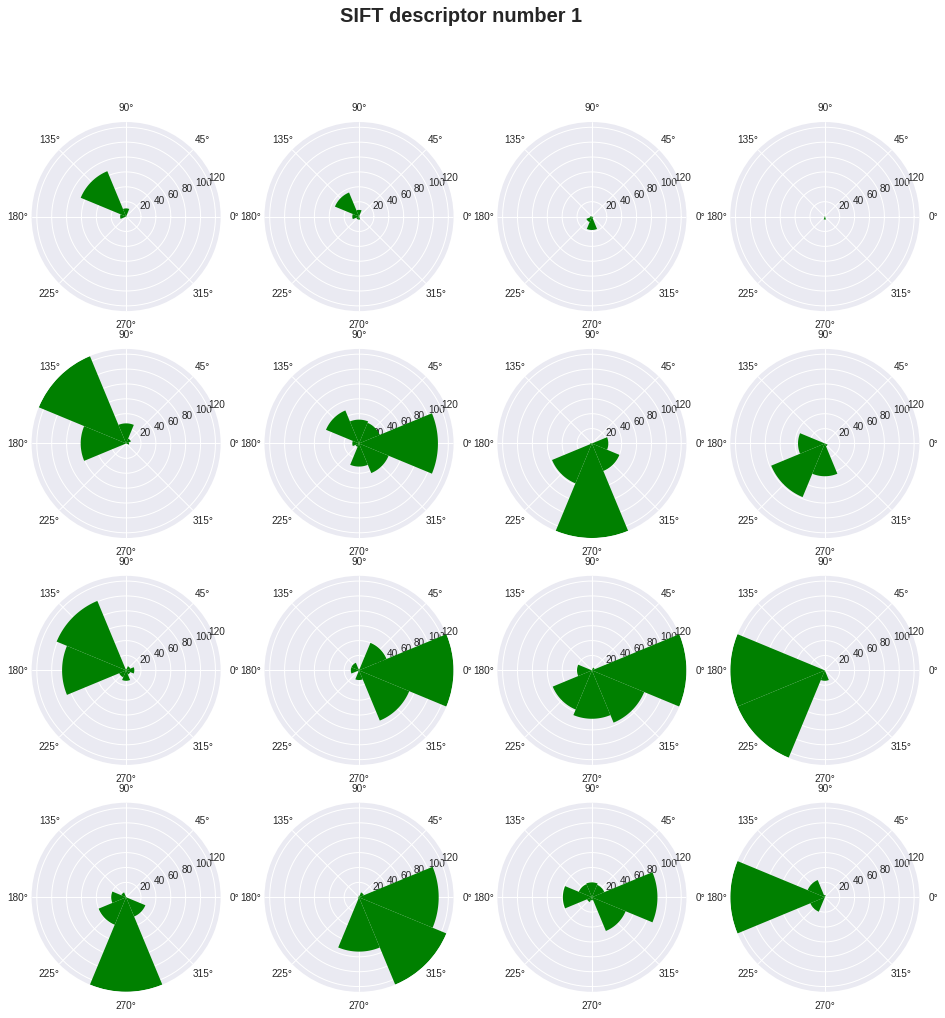

In [0]:
# for curiosity: SIFT descriptor is based on directional gradient
# for better understanding we plot directional roses.

def plot_descriptor_rose(descriptors, idx):
    """ plot 4x4 roses of SIFT descriptor 
    Inputs:
      - descriptors: list of all descriptors
      - idx: index of the unique descriptor that will be plot
      """
    desc = descriptors[idx].reshape(16, 8)
    
    fig = plt.figure(figsize=(16,16))
    fig.suptitle("SIFT descriptor number {}".format(idx), 
                 fontweight="bold", 
                 size=20)
    
    for i in range(16):

        N = 8
        bottom = 0

        theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
        radii = desc[i]
        width = (2*np.pi) / N

        ax = plt.subplot(4, 4, i+1, polar=True)
        bars = ax.bar(theta, radii, width=width, bottom=bottom,  color = "g")
        plt.ylim(0, desc.max() )
    plt.show()
    
# plot of one of the descriptors.
plot_descriptor_rose(sift_descriptors_all, 1)

desciptor shape:  (136, 128)
desciptor shape:  (361, 128)


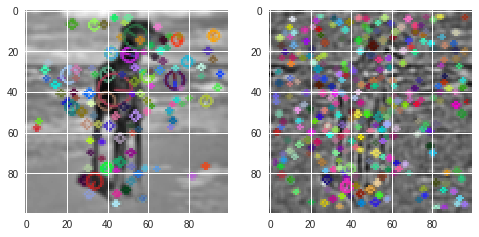

In [0]:
# impact of Inputs (raw gray or whitened images) on SIFT descriptor creation. 

idx = 1
inputs = [X_gray, X_zca]

sift = cv2.xfeatures2d_SIFT.create()

plt.figure(figsize=(8,12))
for i in [0,1]:
    
    resc = rescale(inputs[i][idx], 0, 255)
    resc = resc.astype(np.uint8)
    gray = resc.reshape((100, 100))

    keypoints, descriptors = sift.detectAndCompute(gray, None)

    img = cv2.drawKeypoints(gray,
                            keypoints,
                            outImage=np.array([]),
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.subplot(1, 2, i+1)
    print("desciptor shape: ", descriptors.shape)
    plt.imshow(img, cmap="gray")
plt.show;

From a human point of view (mine :) ), it seems that in thise case, gray images without whitening provide better descriptors: The size of some descriptors seems to match what we want to identify (part of dog's body) and also more concentrate on the dog itself. 
Later on, we will still do a comparaison of both kind of inputs on the final scoring.

### 3.2 SURF

The evaluations carried out suggests strongly that SIFT-based descriptors, which are region-based, are the most robust and distinctive, and are therefore best suited for feature matching. However, most recent feature descriptors such as SURF have not been evaluated in this study.

SURF has later been shown to have similar performance to SIFT, while at the same time being much faster.  Other studies conclude that when speed is not critical, SIFT outperforms SURF. Specifically, disregarding discretization effects the pure image descriptor in SIFT is significantly better than the pure image descriptor in SURF, whereas the scale-space extrema of the determinant of the Hessian underlying the pure interest point detector in SURF constitute significantly better interest points. (Source: [Wikipedia](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform))

In [0]:
surf_keypoints_all, surf_descriptors_all, surf_img_descriptor_idx = compute_descriptors(X_gray, "surf")

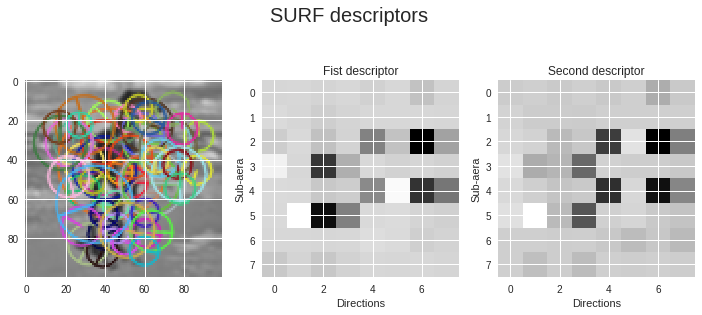

In [0]:
plot_descriptors(X=X_gray, 
                method="surf", 
                img_descriptor_idx=surf_img_descriptor_idx, 
                keypoints_all=surf_keypoints_all, 
                descriptors_all=surf_descriptors_all, 
                img_idx=1, 
                title="SURF descriptors")

### 3.3 ORB

As an OpenCV enthusiast, the most important thing about the ORB is that it came from “OpenCV Labs”. This algorithm was brought up by Ethan Rublee, Vincent Rabaud, Kurt Konolige and Gary R. Bradski in their paper ORB: An efficient alternative to SIFT or SURF in 2011. As the title says, it is a good alternative to SIFT and SURF in computation cost, matching performance and mainly the patents! Yes, SIFT and SURF are patented and you are supposed to pay them for its use. But ORB is not !!!  
ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the performance. First it use FAST to find keypoints, then apply Harris corner measure to find top N points among them. It also use pyramid to produce multiscale-features.  
Source/more info: [OpenCV docs](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_orb/py_orb.html)

In [0]:
orb_keypoints_all, orb_descriptors_all, orb_img_descriptor_idx = compute_descriptors(X_gray, "orb")

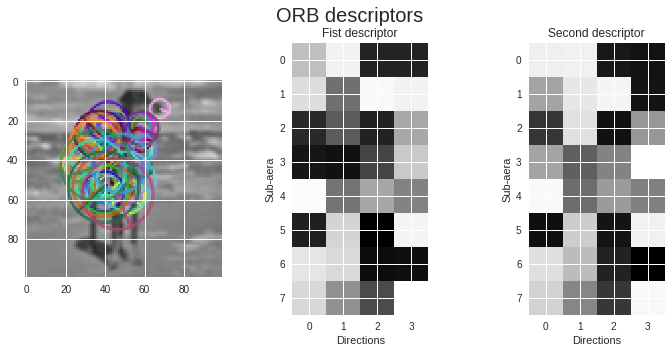

In [0]:
plot_descriptors(X=X_gray, 
                method="orb", 
                img_descriptor_idx=orb_img_descriptor_idx, 
                keypoints_all=orb_keypoints_all, 
                descriptors_all=orb_descriptors_all, 
                img_idx=1, 
                title="ORB descriptors")

## 4  Bag of words
We have now a  list of  a multitude of descriptor for each images. The idea now is to regroup similar features.
For this, we will use a clustering algorithm to regroup them (bag of features). We will use Kmean model.


### 4.1 Kmean Clustering

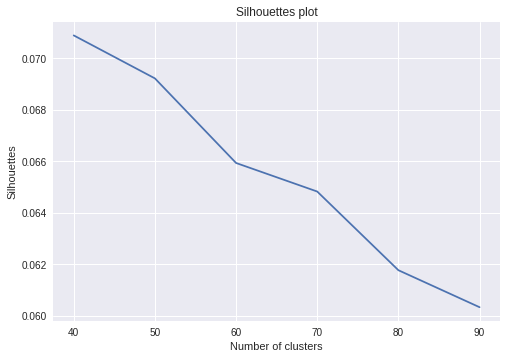

In [0]:
# to start with, as a rule of thumb we will use a number of cluster equal to 10 
# time the number of classes. 
n_cluster = len(set(y))*10

# modle initialisation Kmean
kmeans = KMeans()

# inputs
X_features = surf_descriptors_all

# Test of the number of clustering
min_cluster = 40
max_cluster = 100

silhouettes = []
n_per_groups = []
kmean_centers = []
for num_clusters in range(min_cluster, max_cluster, 10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=111)
    kmeans.fit(X_features)
    silh = metrics.silhouette_score(X_features, kmeans.labels_)
    silhouettes.append(silh)

    # save relvent variable for each runs (centers, number
    # of occurence per clusters)
    kmean_centers.append(kmeans.cluster_centers_)
    # save group repartition
    n_per_groups.append(pd.value_counts(kmeans.labels_))

# Silhouette plot

# inputs
x = list(range(min_cluster, max_cluster, 10))
s = silhouettes

# plot
plt.plot(x, s)
plt.title("Silhouettes plot")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouettes")
plt.show()

We can see that the silouette is very low (no clear clusters) and actually quite constante if we look at the scale.
We choose to continue with 70 clusters (*10 the number of classes)

In [0]:
# inputs
X_features = surf_descriptors_all
kmeans = KMeans(n_clusters=70, random_state=111)
kmeans.fit(X_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=70, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

###4.2 Term Frequency table (tf)
We have now 70 clusters that will be used as feature: For each image we assign each descriptor to a cluster (feature). Then we count the occurence of each feature on each image. We endup with a table NxM where N is the number of image and M the number of features.


In [0]:
# format: group descriptors to features
def format_img_features(img_descriptor_idx, labels_):
    # reformat the dic to an term frequency table
    image_N = []
    for key, values in img_descriptor_idx.items():
        for val in values:
            image_N.append(key)

    img_feat = pd.DataFrame({"images": image_N, "features": labels_})
    pivot_count = pd.crosstab(index=img_feat["images"], columns=img_feat["features"])
    
    # rename features columns
    names_ = []
    for e in  pivot_count.columns:
        names_.append("feat_{}".format(e))
    pivot_count.columns = names_
    
    return pivot_count

In [0]:
# term frequency table 
tf = format_img_features(surf_img_descriptor_idx, kmeans.labels_)
tf.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69
images,,,,,,,,,,,,,,,,,,,,,
0,0,0,2,1,0,3,0,1,0,0,...,1,1,0,0,0,0,1,1,0,1
1,0,0,3,2,0,0,0,0,0,0,...,0,2,0,1,0,1,0,2,0,0
2,0,0,1,1,0,0,0,0,0,2,...,0,1,0,0,2,4,0,1,0,0
3,3,0,0,0,1,2,0,0,2,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,2,0,0,1,0,...,0,0,2,0,0,0,0,1,0,1


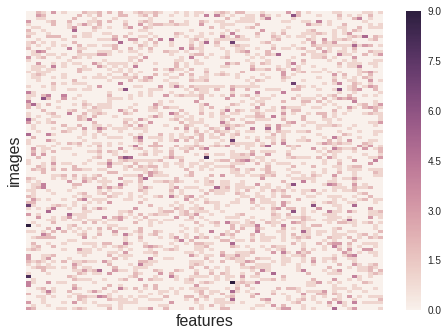

In [0]:
# heatmap on the first 100 images to check the presence of paterns 
sns.heatmap(tf.loc[0:100,:])
plt.xticks([])
plt.yticks([])
plt.xlabel("features", size=16)
plt.ylabel("images", size=16)
plt.show()

No parterns...

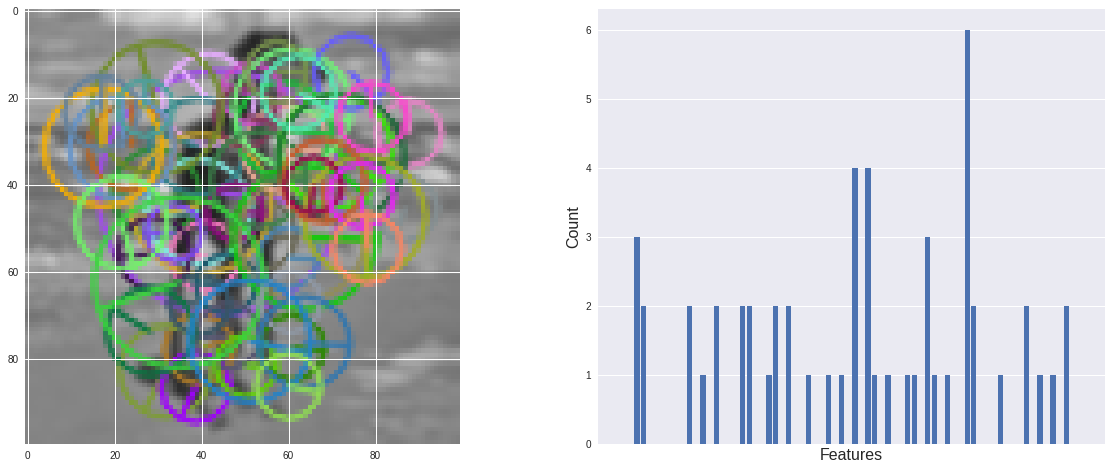

In [0]:
# plot of feature histogram on one picture
idx=1

#inputs
gray = X_gray[idx,:].reshape((IMG_SIZE,IMG_SIZE))
idx_selection = surf_img_descriptor_idx[idx]  # selection of descriptor's idx for this image

# plots
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
img = cv2.drawKeypoints(image=gray,
                        keypoints=surf_keypoints_all[idx],
                        outImage=np.array([]),
                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img, cmap="gray")

plt.subplot(1,2,2)
plt.bar(x=tf.columns, height=tf.loc[idx,:])
plt.xticks([])
plt.ylabel("Count", size=16)
plt.xlabel("Features", size=16)
plt.show();

## 5 Visualisation

We will try two visualisations (dimention reduction to 2D):


*   t-SNE
*   PCA



### 5.1 t-SNE

In [0]:
## t-SNE
from sklearn import manifold
from sklearn import preprocessing

tsne = manifold.TSNE(n_components=2, perplexity=60, n_iter=3000, init='pca')
X_tsne = tsne.fit_transform(X_scal)

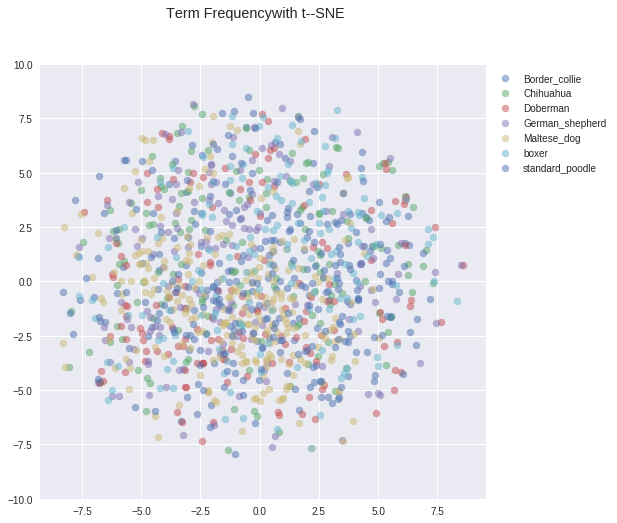

In [0]:
# vizualisation
plt.figure(figsize=(8, 8))
plt.suptitle("Term Frequencywith t--SNE")
for g in np.unique(y):
    ix = [i for i, val in enumerate(y) if val == g]
    plt.scatter(X_tsne[ix,0], X_tsne[ix,1], s=50, label=g, alpha=0.5)
    plt.ylim([-10,10])
plt.legend(bbox_to_anchor=(1.0,1.0))

plt.show()

### 5.2 PCA

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


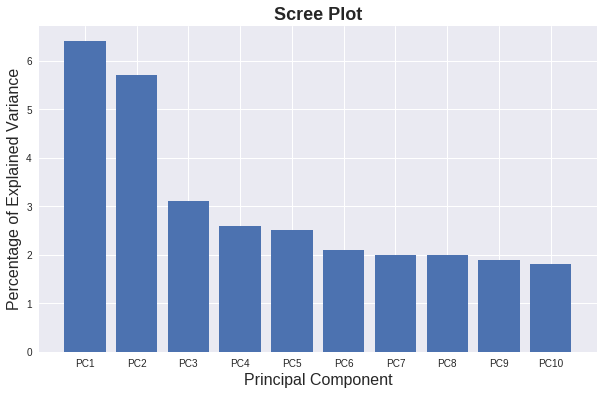

In [0]:
# PCA


# scale inputs
X_scal = preprocessing.scale(tf)
# X_scal = pd.DataFrame(X_scal, columns=features_selection)

# model
pca = PCA()  # create a PCA object
pca.fit(X_scal)  # do the math

# get PCA coordinates for scaled_data (return nparray)
pca_data = pca.transform(X_scal)

# Draw a scree plot and a PCA plot
per_var = np.round(pca.explained_variance_ratio_[:10] * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

plt.figure(figsize=(10, 6))
plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance', size=16)
plt.xlabel('Principal Component', size=16)
plt.title("Scree Plot", size=18, fontweight="bold")
plt.show()

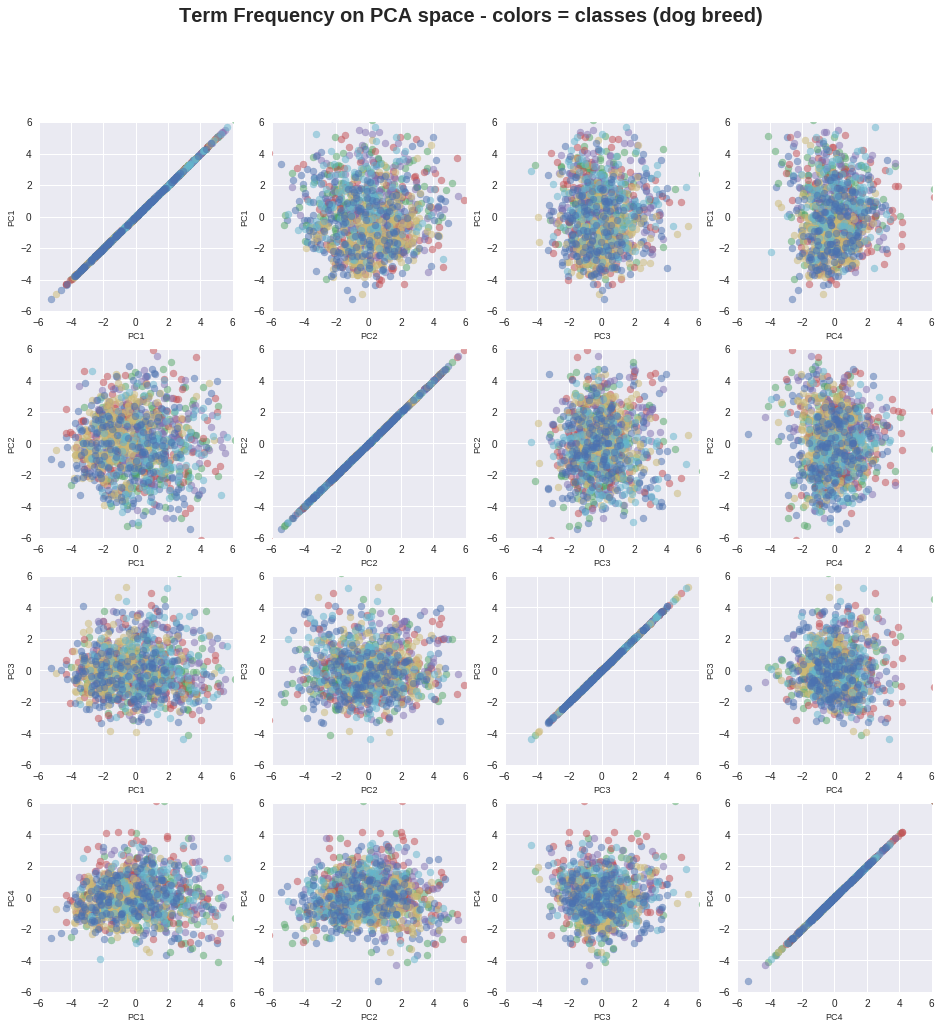

In [0]:
# Plots on the 4 first components

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

# inputs plot1
pca_df = pd.DataFrame(pca_data, columns=labels)
PCA_C = ["PC1", "PC2", "PC3", "PC4"]

# plot
plt.figure(figsize=(16, 16))
plt.suptitle("Term Frequency on PCA space - colors = classes (dog breed)", 
             fontweight="bold", 
             size=20)
i=1
for composent_x in PCA_C:
    for composent_y in PCA_C:
        plt.subplot(4,4,i)
        for g in np.unique(y):
            ix = [i for i, val in enumerate(y) if val == g]   # :)
            plt.scatter(pca_df.loc[ix,composent_y], 
                        pca_df.loc[ix,composent_x], 
                        label = g, 
                        s = 50, 
                        alpha = 0.5)
            plt.ylabel(composent_x, size=9)
            plt.xlabel(composent_y, size=9)
#             plt.legend()
            plt.xlim([-6, 6])
            plt.ylim([-6, 6])
        i = i+1
plt.show()

With 2D vizualisation (PCA or t-SNE), there is no visible clustering or paterns.  Models might have some difficulties to perform well.

## 6 Modelisation
In this section we will use supervised learning to predict the dog breed.  
Inputs are:  
- X = term frequency table (tf) based on SURF and clusterized on 70 features  
- y = dog breed  


We will try 4 models combined with gridsearch on some parameters:  
- Gaussian Naive Bayes
- Knn
- Random Forest
- SVM

In [0]:
# stratified split data
X_train, X_test, y_train, y_test = train_test_split(tf, y, random_state=0,
                                                    stratify=y,
                                                    train_size=0.8)

### 6.1 models

In [0]:
# models
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics

# model lib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from time import time
t0 = time()

# Gaussian Naive Bayes
param_grid = {'var_smoothing': [1e-10, 1e-09, 1e-08, 1e-07],}
gauss_grid = GridSearchCV(GaussianNB(), param_grid, cv=6, scoring="f1_macro")
gauss_grid.fit(X_train, y_train)
y_pred_gauss = gauss_grid.predict(X_test)
print("Gaussian Naive Bayes done in: ", round((time() - t0)/60,0), " min")
t0 = time()

# K Neighbors Classifier with scalled input
scale_knn = Pipeline(steps=[('scaller', StandardScaler()),
                            ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': np.arange(2, 16, 2),}
scale_knn_grid = GridSearchCV(scale_knn, param_grid, cv=6, scoring="f1_macro")
scale_knn_grid.fit(X_train, y_train)
y_pred_scale_knn = scale_knn_grid.predict(X_test)
print("K Neighbors done in: ", round((time() - t0)/60,0), " min")
t0 = time()

# Random Forest
param_grid = {'max_depth': [10, 20, None],}
rf_grid = GridSearchCV(RandomForestClassifier(n_estimators=100,
                                           random_state=0),
                    param_grid, cv=6,
                    scoring="f1_macro")
rf_grid.fit(X_train, y_train)
y_pred_rf = rf_grid.predict(X_test)
print("Random Forest done in: ", round((time() - t0)/60,0), " min")
t0 = time()

# Support Vector Machine
param_grid = {"gamma": ["auto", "scale"]}
svm_grid = GridSearchCV(SVC(), param_grid, cv=6, scoring="f1_macro")
svm_grid.fit(X_train, y_train)
y_pred_svm = svm_grid.predict(X_test)
print("Support Vector Machine done in: ", round((time() - t0)/60,0), " min")

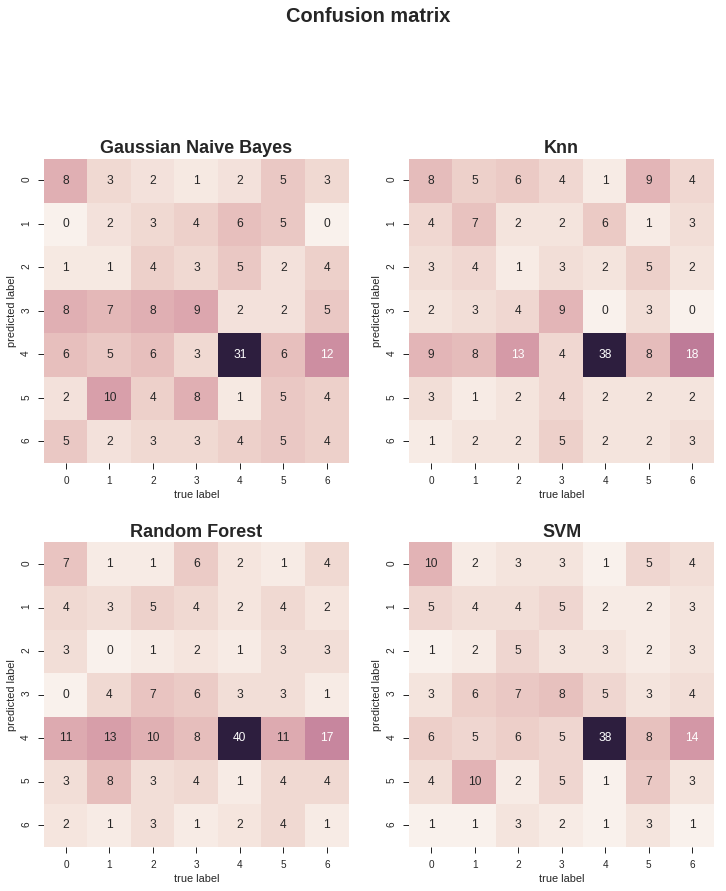

In [0]:
# confusion matrix
from sklearn.metrics import confusion_matrix

# inputs
model_name  = ["Gaussian Naive Bayes", "Knn", "Random Forest", "SVM"]
y_pred_models = [y_pred_gauss, y_pred_scale_knn, y_pred_rf, y_pred_svm]

# plot
sns.set(style="ticks", palette="pastel")
fig = plt.figure(figsize=(12,20))
fig.suptitle("Confusion matrix", fontweight="bold", size=20)
for i,y_pred in enumerate(y_pred_models):
    plt.subplot(3,2,i+1) 
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.title(model_name[i], fontweight="bold",size = 18)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [0]:
# metrics comparaison
for i,y_pred in enumerate(y_pred_models):
    print(model_name[i])
    print(metrics.classification_report(y_pred, y_test))
    print("---------------------------------------------------------\n")

Gaussian Naive Bayes
                 precision    recall  f1-score   support

  Border_collie       0.27      0.33      0.30        24
      Chihuahua       0.07      0.10      0.08        20
       Doberman       0.13      0.20      0.16        20
German_shepherd       0.29      0.22      0.25        41
    Maltese_dog       0.61      0.45      0.52        69
          boxer       0.17      0.15      0.16        34
standard_poodle       0.12      0.15      0.14        26

      micro avg       0.27      0.27      0.27       234
      macro avg       0.24      0.23      0.23       234
   weighted avg       0.31      0.27      0.29       234

---------------------------------------------------------

Knn
                 precision    recall  f1-score   support

  Border_collie       0.27      0.22      0.24        37
      Chihuahua       0.23      0.28      0.25        25
       Doberman       0.03      0.05      0.04        20
German_shepherd       0.29      0.43      0.35        21


The best f1-score is obtain with support vector machine. However the score is quite low.
It seems that this combinaison of inputs and models are quite limited to this perfome this task of breed reconition.
In the next section we will try to get a better score by changing the inputs:  
- gray or whitened images
- descriptor algorithms (sift, surf, orb)

### 6.2 inputs optimisation

In [0]:
# models
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler  # 0.45
from sklearn import metrics

# model lib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from time import time
t0 = time()

from sklearn.metrics import f1_score
  
  # optimisation on inputs and descriptor algorithm
import warnings          # to clean notebook from minor warnings
warnings.filterwarnings('ignore')

## grid results array
grid_score_rf = pd.DataFrame(0, 
                          index=[0, 1], 
                          columns=["sift", "surf", "orb"]) 
grid_score_rf.index.name = "inputs"
grid_score_rf.columns.name = "algo"
grid_score_svm = grid_score_rf.copy()

for i, X in enumerate([X_gray, X_zca]):
    for algo in ["orb", "surf", "sift"]:

        # descriptors
        keypoints_all, descriptors_all, img_descriptor_idx = compute_descriptors(X, algo)

        # clustering
        X_features = descriptors_all
        kmeans = KMeans(n_clusters=70, random_state=111)
        kmeans.fit(X_features)

        # term frequency
        tf = format_img_features(img_descriptor_idx, kmeans.labels_)

        # split data
        X_train = tf.loc[train_idx, :]
        X_test = tf.loc[test_idx, :]
        y_train = y[train_idx]
        y_test = y[test_idx]

        # Models -----------------------------------------------------------------------
        # Random Forest
        param_grid = {'max_depth': [10, 20, None]}
        rf_grid = GridSearchCV(RandomForestClassifier(n_estimators=100,
                                                   random_state=0),
                            param_grid, cv=6,
                            scoring="f1_macro")
        rf_grid.fit(X_train, y_train)
        y_pred_rf = rf_grid.predict(X_test)
        print("Random Forest done in: ", round((time() - t0)/60,0), " min")
        t0 = time()

        # Support Vector Machine
        param_grid = {"gamma": ["auto", "scale"]}  # gamma 0.01, 0.001, 0.0001
        svm_grid = GridSearchCV(SVC(), param_grid, cv=6, scoring="f1_macro")
        svm_grid.fit(X_train, y_train)
        y_pred_svm = svm_grid.predict(X_test)
        print("Support Vector Machine done in: ", round((time() - t0)/60,0), " min")
        
        grid_score_rf.loc[i, algo] = f1_score(y_pred_rf, y_test, average="weighted")
        grid_score_svm.loc[i, algo] = f1_score(y_pred_svm, y_test, average="weighted") 
        print(round((time() - t0)/60,0), " min","  i=",i," algo=", algo,"   Score RF:", round(grid_score_rf.loc[i, algo],3), "    score SVM:", round(grid_score_svm.loc[i, algo],3))

In [0]:
# Random Forest scores
grid_score_rf

algo,sift,surf,orb
inputs,,,
0,0.322982,0.31026,0.322294
1,0.293941,0.27781,0.306261


In [0]:
# SVM scores
grid_score_svm

algo,sift,surf,orb
inputs,,,
0,0.338528,0.316327,0.347037
1,0.321037,0.340243,0.321511


SVM with orbs descriptor and gray images have the best score. However it is still quite low.
Overall, it seems that gray images (without whitening) help to perform better. The open source ORB perform as good as SURF and SIFT.

## 7 Conclusion

Even performed with 7 breeds only, we can already see the limitation of the standard model for this task. further optimisation ideas:


1.   Increase the number of images. With the actual set, there are only ~ 300 images per breeds. This can sound quite low to train some models.
2.  Reprocessing step is important and could be explored. We have resize the image to 100x100. We could find a more optimum size that help model to build better descriptors. Note also that the "resize" changed the shape of the image.
3.   We could also have done an area selection (without stretching images). or use pading.
4. Work with "raw" pixel values (without descriptors)
4.   Keep colours
5.   Nowadays, one of the popular approaches for analysing visual imagery is Convolutional Neural Network (CNN). This technique can be tested here.


Good ressource: 
*   [Ian London's blog](https://ianlondon.github.io/blog/how-to-sift-opencv/)





